In [1]:
# NOTICE!!!!
# replace 'E' in the equation with 'e' as sympy would treat 'E' as numerical value e.
##################

import sympy as sp
import pandas as pd

# Define custom operations using subclassing of sympy.Function
class Add(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x + y

class Sub(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x - y

class Mul(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x * y

class Div(sp.Function):
    @classmethod
    def eval(cls, x, y):
        try:
            result = sp.Piecewise(
                (1, sp.Eq(y, 0)),  # Return 1 if y is exactly zero
                (1, sp.Eq(y, sp.zoo)),  # Return 1 if y is exactly zero
                (x / y, True)           # Normal division otherwise
            )
            return result.simplify()  # Simplify to handle potential further issues
        except Exception as e:
            print(f"Division error: {e}")
            return 1000  # Return NaN on error
        
# Define the custom operations using subclassing of sympy.Function
class Div_for_visualization(sp.Function):
    @classmethod
    def eval(cls, x, y):
        # Use Piecewise to handle division by zero robustly
        return x / y

class Neg(sp.Function):
    @classmethod
    def eval(cls, x):
        return -x
    

# Update converter for sympify to recognize custom classes
converter = {
    'add': Add,
    'sub': Sub,
    'mul': Mul,
    'div': Div,
    'neg': Neg,
}

# Update converter for sympify to recognize custom classes
converter_vis = {
    'add': Add,
    'sub': Sub,
    'mul': Mul,
    'div': Div_for_visualization,
    'neg': Neg,
}

# Function to apply the equation to each row of the DataFrame
def apply_equation(row):
    # Replace variables in the expression with row data
    local_env = {
        'Pr': row['Pr'],
        'La': row['La'],
        'Gd': row['Gd'],
        'Nd': row['Nd'],
        'Ce': row['Ce'],
        'Sm': row['Sm'],
        'Y' : row['Y'],
        "EN": row['EN'],
        'R' : row['R'],
        'IE': row['IE'],
        'LAS': row['LAS'],
        'M' : row['M'],
        'e' : row['E'],
    }
    try:
        result = expr.subs(local_env)
        # Force numeric evaluation if the result is not numeric
        if isinstance(result, sp.Expr):  # Check if result is still a symbolic expression
            result = result.evalf()  # Evaluate numerically
        # if result == sp.zoo:
        #     result = 1
    except Exception as e:
        print(f"Error evaluating row: {local_env}")
        print(f"Error message: {str(e)}")
        result = None  # Optional: handle error case by assigning a default value or None
    return result

    # print("Local Environment:", local_env)  # Debug: Print the local environment for a row
    # return expr.subs(local_env)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pickle

-0.482*La + 0.482*M + 0.482*R + 0.482*e + (0.482*LAS - 1.989696)/(Nd*(LAS - M))
[-0.34574062  0.51577359  0.28101732  0.46136988  1.08671949] 0.44058513314475345
RMSE: 0.7101903920723565
RMSE_original: 0.006155262350965244
R^2 score: 0.4956285937784122


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


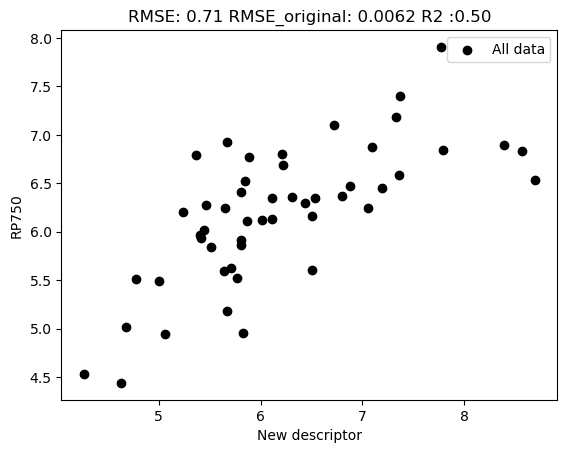

In [15]:
equ = "-0.482*La + 0.482*M + 0.482*R + 0.482*e + 0.482*(LAS - 4.128)/(Nd*(LAS - M))"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./all_rp750.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("La", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("M", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("R", locals=converter,evaluate=True)
df['c'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['d'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("0.482*(LAS - 4.128)/(Nd*(LAS - M))", locals=converter,evaluate=True)
df['e'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -5:].values
Y = df.iloc[:, -6].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[0]
    std = scaler.scale_[0]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='All data')
plt.xlabel('New descriptor')
plt.ylabel('RP750')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('all_rp750_pred_split.xlsx', index=False)


EN + (Ce - 7.983/(Ce + 4.263*Gd - 4.263*e))/EN
[0.80859781 1.01135403] 0.8810994602535196
RMSE: 0.581468134808646
RMSE_original: 0.005039618894349943
R^2 score: 0.7099881431094865


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


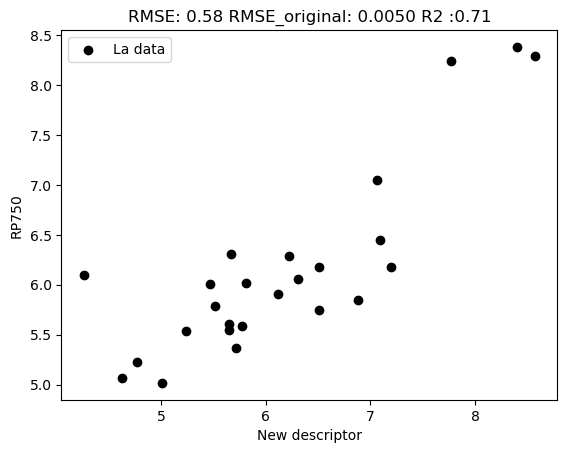

In [16]:
equ = "EN + (Ce - 7.983/(Ce + 4.263*Gd - 4.263*e))/EN"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./La_rp750.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("EN", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(Ce - 7.983/(Ce + 4.263*Gd - 4.263*e))/EN", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -2:].values
Y = df.iloc[:, -3].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[0]
    std = scaler.scale_[0]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='La data')
plt.xlabel('New descriptor')
plt.ylabel('RP750')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('La_rp750_pred_split.xlsx', index=False)

1.31397174254317*EN - 0.313971742543171*Pr + 0.51679748822606 + (EN - R)/(e*(4.966 - Nd))
[ 1.47387014 -0.43245686  1.07823205] 0.3753563669539499
RMSE: 0.6370369858971903
RMSE_original: 0.005521237430463372
R^2 score: 0.5734663342212144


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


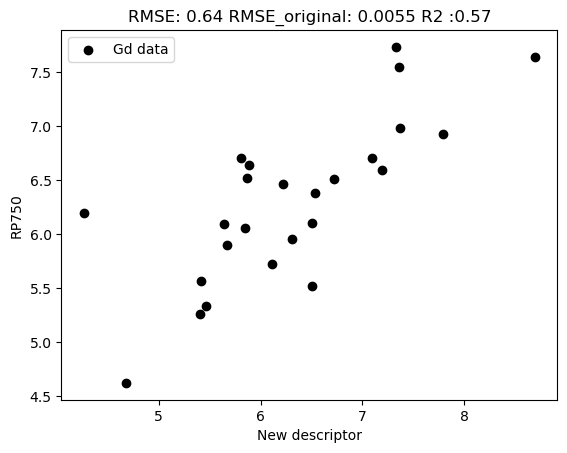

In [17]:
equ = "1.31397174254317*EN - 0.313971742543171*Pr + 0.51679748822606 + (EN - R)/(e*(4.966 - Nd))"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Gd_rp750.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("EN", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("Pr", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(EN - R)/(e*(4.966 - Nd))", locals=converter,evaluate=True)
df['c'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -3:].values
Y = df.iloc[:, -4].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[0]
    std = scaler.scale_[0]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Gd data')
plt.xlabel('New descriptor')
plt.ylabel('RP750')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Gd_rp750_pred_split.xlsx', index=False)

0.498*Ce + 0.498*EN/(R - 4.233/(EN*(EN - Pr))) + 0.498*e
[0.62358355 0.57251536 0.4574505 ] -0.6222307867821151
RMSE: 0.6048264501826118
RMSE_original: 0.005242066802415553
R^2 score: 0.6598820124163476


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


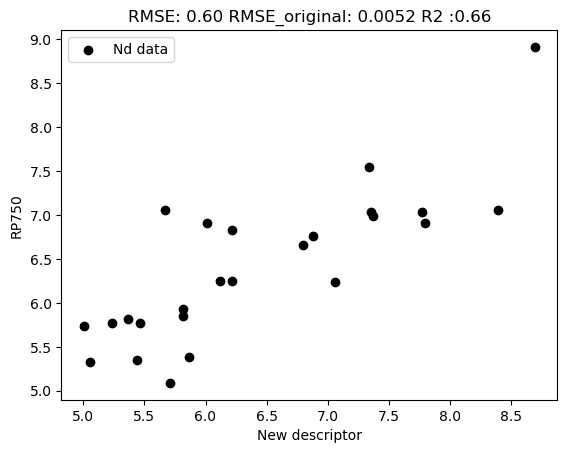

In [25]:
equ = "0.498*Ce + 0.498*EN/(R - 4.233/(EN*(EN - Pr))) + 0.498*e"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Nd_rp750.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("Ce", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("EN/(R - 4.233/(EN*(EN - Pr)))", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['c'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -3:].values
Y = df.iloc[:, -4].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[0]
    std = scaler.scale_[0]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Nd data')
plt.xlabel('New descriptor')
plt.ylabel('RP750')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Nd_rp750_pred_split.xlsx', index=False)

6.986 - entropy*(Gd - La)/(Gd*M*(-La + entropy))
[1.06054013] 6.94322658060204
RMSE: 0.7276149354527262
RMSE_original: 0.006306281904382439
R^2 score: 0.46743137888710473


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


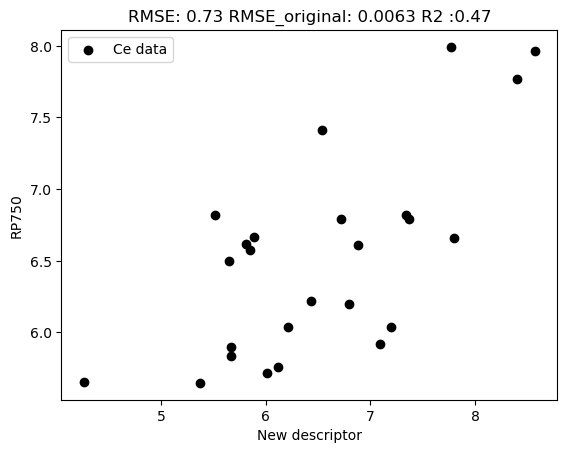

In [17]:
equ = "6.986 - entropy*(Gd - La)/(Gd*M*(-La + entropy))"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Ce_rp750.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("div(div(neg(e), div(mul(Gd, sub(e, La)), sub(Gd, La))), M)", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -1].values.reshape(-1,1)
Y = df.iloc[:, -2].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
# model.coef_ = np.array([-1]) 
# model.intercept_ = 6.986 
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[0]
    std = scaler.scale_[0]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Ce data')
plt.xlabel('New descriptor')
plt.ylabel('RP750')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Ce_rp750_pred_split.xlsx', index=False)

e + (Sm - e)/e + (Ce - 4.557)/(Gd*(R - Y))
[3.40606518 9.87558152 1.15064399] -16.18305652659493
RMSE: 0.5184223397674825
RMSE_original: 0.0044931972404732064
R^2 score: 0.747333414002686


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


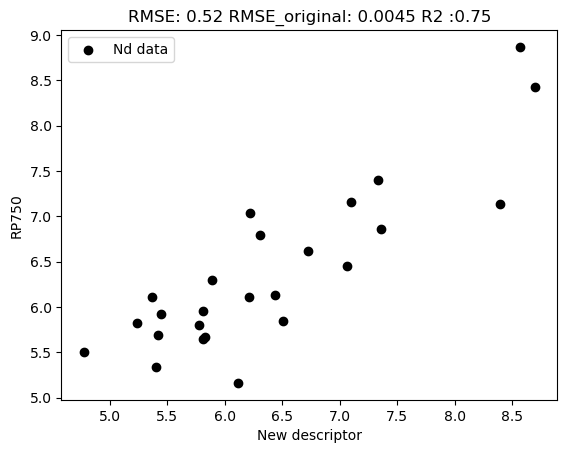

In [4]:
equ = "add(div(sub(Sm, e), e), add(div(div(sub(Ce, 4.557), sub(R, Y)), Gd), e))"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Sm_rp750.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(Sm - e)/e", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(Ce - 4.557)/(Gd*(R - Y))", locals=converter,evaluate=True)
df['c'] = df.apply(apply_equation, axis=1)

# Use the second column as X and the first as Y
X = df.iloc[:, -3:].values
Y = df.iloc[:, -4].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[0]
    std = scaler.scale_[0]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Nd data')
plt.xlabel('New descriptor')
plt.ylabel('RP750')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Sm_rp750_pred_split.xlsx', index=False)

e - (Gd - e)/(Gd*(Gd - 3.69)*(R - Y))
[ 0.87268032 -1.15224783] 0.7953233392826125
RMSE: 0.5636300109098827
RMSE_original: 0.004885014813991272
R^2 score: 0.7014175390622712


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


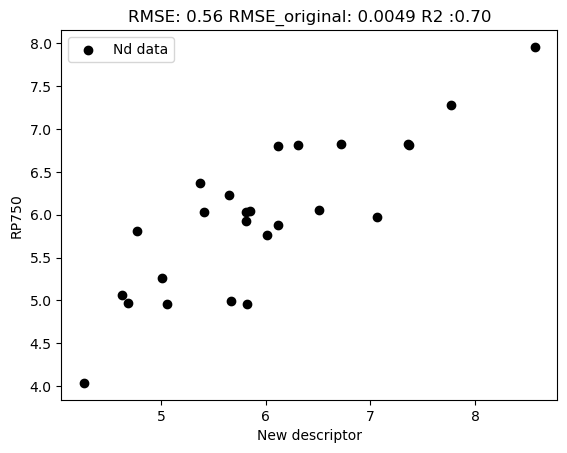

In [5]:
equ = "add(div(sub(Gd, e), mul(mul(add(Gd, -3.690), neg(Gd)), sub(R, Y))), e)"
expr = sp.sympify(equ, locals=converter_vis)
print(expr)

# Read the Excel file
df = pd.read_excel('./Y_rp750.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

expr = sp.sympify("e", locals=converter,evaluate=True)
df['a'] = df.apply(apply_equation, axis=1)

expr = sp.sympify("(Gd - e)/(Gd*(Gd - 3.69)*(R - Y))", locals=converter,evaluate=True)
df['b'] = df.apply(apply_equation, axis=1)


# Use the second column as X and the first as Y
X = df.iloc[:, -2:].values
Y = df.iloc[:, -3].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[0]
    std = scaler.scale_[0]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='Nd data')
plt.xlabel('New descriptor')
plt.ylabel('RP750')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
df.to_excel('Y_rp750_pred_split.xlsx', index=False)